# Calculate CMIP Indeces

This file 
1. calculates all the indeces for all months for all cesmFullForcingFiles.



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
#warnings.filterwarnings('ignore')

# 1. Calculate CMIP Indeces

For each experiment in historical, calculate indices

In [4]:
deckSet=['piControl','historical']
scenarioSet=['ssp126', 'ssp245', 'ssp370','ssp585']
experimentSet=[*deckSet, *scenarioSet]

In [43]:
modelSet=_model.scenarioMip

In [6]:
modelSet

array([['INM', 'INM-CM4-8', 'r1i1p1f1', 'r1i1p1f1'],
       ['INM', 'INM-CM5-0', 'r1i1p1f1', 'r1i1p1f1'],
       ['MPI-M', 'MPI-ESM1-2-HR', 'r1i1p1f1', 'r1i1p1f1']], dtype='<U19')

In [7]:
sstIndeces = _index.sstIndex.keys()
pslIndeces = _index.pslIndex

In [8]:
len(modelSet)

3

Climatology and piControl:

In [40]:
for iModel in modelSet:
    
    print(iModel)
    
    try: 
        #calculate climatology
        
        print(iModel[1] + ' starting') 
        #SST
        tsDs = fh.loadModelData(iModel[1], 'ts_Amon', 'piControl', iModel[2]).ts.to_dataset()
        controlDs=tsDs.assign_attrs({'project_id':'CMIP'})
        sstClimat=sst.calculateClimatology(controlDs)

        [sstClimat[i].to_netcdf('results/cmipMonthlyIndeces/sstClimat'+iModel[1]+i+'.nc')
             for i in sstIndeces]

        pslControlDs=fh.loadModelData(iModel[1], 'psl_Amon', 'piControl', iModel[2])
        pslClimat=psl.calculateClimatology(pslControlDs)

        pslClimat.to_netcdf('results/cmipMonthlyIndeces/pslClimat'+iModel[1]+'.nc')

    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

['EC-Earth-Consortium' 'EC-Earth3-Veg' 'r1i1p1f1' 'r1i1p1f1']
EC-Earth3-Veg starting


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1387: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [41]:
for iModel in modelSet:
    
    print(iModel)
    
    try:
        sstClimat=dict()

        for i in sstIndeces:
            sstClimat[i]=xarray.open_dataarray('results/cmipMonthlyIndeces/sstClimat'+iModel[1]+i+'.nc')
        #the piControl
        tsDs = fh.loadModelData(iModel[1], 'ts_Amon', 'piControl', iModel[2]).ts.to_dataset()
        controlDs=tsDs.assign_attrs({'project_id':'CMIP'})
        sstIndex = sst.calculateIndex(controlDs, sstClimat) 
        
        pslClimat=xarray.open_dataset('results/cmipMonthlyIndeces/pslClimat'+iModel[1]+'.nc')
        pslControlDs=fh.loadModelData(iModel[1], 'psl_Amon', 'piControl', iModel[2])
        pslIndex, junk = psl.calculateSamIndex(pslControlDs, pslClimat)
        
        indeces = xarray.merge([pslIndex, sstIndex])
        indeces.assign_attrs(climatology='full length of pi Control')
        print('Caclulating control ...')
        tp.averageForTimePeriod(indeces).to_netcdf(
            'results/cmipWarmSeasonIndeces/'+iModel[1]+'_piControl.nc')
        
    except Exception as e:
        print(iModel[1] + "piControl did not calculate")
        print(e)

['EC-Earth-Consortium' 'EC-Earth3-Veg' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1387: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Caclulating control ...


Historical Indeces

In [ ]:
for iModel in modelSet:
    
    print(iModel)
    
    try:    

        sstClimat=dict()

        for i in sstIndeces:
            sstClimat[i]=xarray.open_dataarray('results/cmipMonthlyIndeces/sstClimat'+iModel[1]+i+'.nc')
        pslClimat=xarray.open_dataset('results/cmipMonthlyIndeces/pslClimat'+iModel[1]+'.nc')

        #historical
        tsDs = fh.loadModelData(iModel[1], 'ts_Amon', 'historical', iModel[3]).ts.to_dataset()
        #sstDs = xarray.merge([tsDs.ts, fxDs.areacella])
        sstDs=tsDs.assign_attrs({'project_id':'CMIP'})

        sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)

        pslDs = fh.loadModelData(iModel[1], 'psl_Amon', 'historical',iModel[3])
        pslIndex, junk = psl.calculateSamIndex(pslDs, pslClimat)
        indeces = xarray.merge([pslIndex, sstIndex])
        indeces.assign_attrs(climatology='full length of pi Control')
        #print(indeces)
        print('Caclulating historical ...')

        #save the results to file
        indeces.to_netcdf('results/cmipMonthlyIndeces/'+iModel[1]+'_historical.nc')
        tp.averageForTimePeriod(indeces).to_netcdf('results/cmipWarmSeasonIndeces/'+iModel[1]+'_historical.nc')

    except Exception as e:
        print(iModel[1] + "historical did not calculate")
        print(e)
        

['CSIRO-ARCCSS' 'ACCESS-CM2' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index

Caclulating historical ...
['CSIRO' 'ACCESS-ESM1-5' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index i

Caclulating historical ...
['AWI' 'AWI-CM-1-1-MR' 'r1i1p1f1' 'r1i1p1f1']
Caclulating historical ...
['BCC' 'BCC-CSM2-MR' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index i

Caclulating historical ...


Scenario Indeces

In [17]:
for iModel in modelSet:
    
    print(iModel)
    
    try: 

#ref to the saved files
        historicalIndeces = xarray.open_dataset('results/cmipMonthlyIndeces/'+iModel[1]+'_historical.nc')
        
        sstClimat=dict()
        
        for i in sstIndeces:
            sstClimat[i]=xarray.open_dataarray('results/cmipMonthlyIndeces/sstClimat'+iModel[1]+i+'.nc')
        pslClimat=xarray.open_dataset('results/cmipMonthlyIndeces/pslClimat'+iModel[1]+'.nc')
        
        for experiment in scenarioSet: 
            try:
                variant = iModel[3]
                
                tsDs = fh.loadModelData(iModel[1], 'ts_Amon', experiment, variant).ts.to_dataset()
                #sstDs = xarray.merge([tsDs.ts, fxDs.areacella])
                sstDs=tsDs.assign_attrs({'project_id':'CMIP'})

                sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)

                pslDs = fh.loadModelData(iModel[1], 'psl_Amon', experiment,variant)
                pslIndex, junk = psl.calculateSamIndex(pslDs, pslClimat)

                indeces = xarray.concat([
                    historicalIndeces, 
                                         xarray.merge([pslIndex, sstIndex])
                    ], 'time')

                indeces.assign_attrs(climatology='full length of pi Control')
                #print(indeces)
                print('Caclulating ...')
                tp.averageForTimePeriod(indeces).to_netcdf('results/cmipWarmSeasonIndeces/'+iModel[1]+'_'+experiment + '.nc')

            except Exception as e:
                print(iModel[1] + experiment + " not completed: ")
                print(e)
                
            else:
                print(iModel[1] + experiment + ' complete')  

    except Exception as e:
        print(e)
        
    else:
        print(iModel[1] + ' finished')

['INM' 'INM-CM4-8' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM4-8ssp126 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM4-8ssp245 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM4-8ssp370 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM4-8ssp585 complete
INM-CM4-8 finished
['INM' 'INM-CM5-0' 'r1i1p1f1' 'r1i1p1f1']


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM5-0ssp126 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM5-0ssp245 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM5-0ssp370 complete


/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is ge

Caclulating ...
INM-CM5-0ssp585 complete
INM-CM5-0 finished
['MPI-M' 'MPI-ESM1-2-HR' 'r1i1p1f1' 'r1i1p1f1']
Caclulating ...
MPI-ESM1-2-HRssp126 complete
Caclulating ...
MPI-ESM1-2-HRssp245 complete
Caclulating ...
MPI-ESM1-2-HRssp370 complete
Caclulating ...
MPI-ESM1-2-HRssp585 complete
MPI-ESM1-2-HR finished


This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [18]:
for experiment in experimentSet: 
    print(experiment)
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        try:
            indecesDs = xarray.open_dataset('results/cmipWarmSeasonIndeces/' + model +'_'+ experiment + '.nc')
            indecesDs['model']=model
            timePIndeces.append(indecesDs)
        except Exception as e:
            print('skipping' + model + experiment) 
    results=xarray.concat(timePIndeces, 'model')

    results=results.assign_attrs({'experiment':experiment,**indecesDs.attrs,**_index.monthsOfInterest})

    results.to_netcdf('results/cmip6'+experiment+'TradIndeces.nc')

piControl
historical
ssp126
skippingEC-Earth3-CCssp126
skippingGFDL-CM4ssp126
ssp245
skippingHadGEM3-GC31-MMssp245
ssp370
skippingCIESMssp370
skippingCNRM-CM6-1-HRssp370
skippingEC-Earth3-CCssp370
skippingFIO-ESM-2-0ssp370
skippingGFDL-CM4ssp370
skippingHadGEM3-GC31-LLssp370
skippingHadGEM3-GC31-MMssp370
skippingKIOST-ESMssp370
skippingNESM3ssp370
ssp585


In [19]:
results.sel(year=slice(1850,2099))

<xarray.Dataset>
Dimensions:          (model: 41, year: 250)
Coordinates:
  * year             (year) int64 1850 1851 1852 1853 ... 2096 2097 2098 2099
  * model            (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eastIO           (model, year) float64 -0.4181 0.1746 ... -1.822 -0.9701
    eastIONoDetrend  (model, year) float64 -0.6911 0.1058 ... 4.195 4.902
    nino34NoDetrend  (model, year) float64 -0.3749 0.7279 1.151 ... 5.128 5.409
    nino34           (model, year) float64 -0.1331 0.7068 ... -0.8731 -0.5127
    nino4NoDetrend   (model, year) float64 -0.1801 0.4664 0.8271 ... 5.104 5.216
    dmi              (model, year) float64 0.5142 0.04047 ... 1.066 0.5196
    sam              (model, year) float64 -0.8385 -4.552 -0.7628 ... nan nan
    nino4            (model, year) float64 0.06169 0.4452 ... -0.8968 -0.7058
Attributes: (12/13)
    experiment:       ssp585
    nino34NoDetrend:  [7, 15]
    nino4NoDetrend:   [7, 15]
    eastIONoDetrend:  [7, 12]
    dmi:              [7, 12]
    nino34:           [7, 15]
    ...               ...
    eastIO:           [7, 12]
    sam:              [10, 15]
    lat1:             [10, 15]
    lat2:             [10, 15]
    precAnom:         [10, 15]
    tsAnom:           [10, 15]

Some sanity checks to see if it looks ok:


In [20]:
results=xarray.open_dataset('results/cmip6ssp585TradIndeces.nc').sel(year=slice(1850,2099))

In [21]:
str(results.isel(model=6).model.values)

'CESM2'

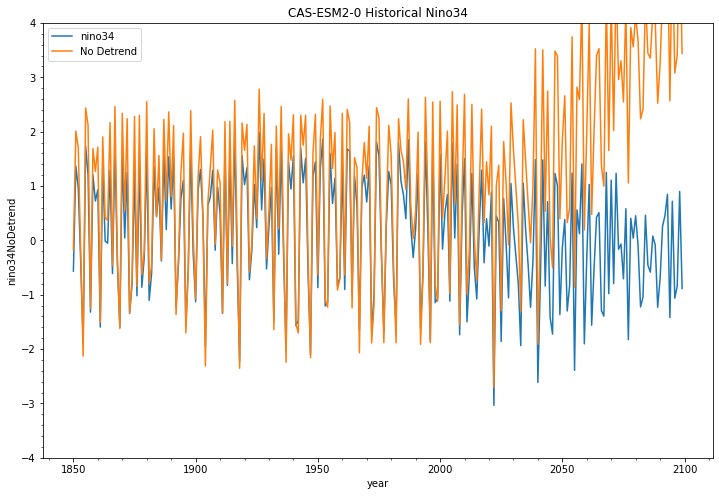

In [22]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

results.isel(model=5).nino34.plot(label='nino34')
results.isel(model=5).nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title(str(results.isel(model=5).model.values) + " Historical Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [23]:
# A multi-model mean?

mean = results.sam.mean(dim='model')
std = results.sam.std(dim='model')

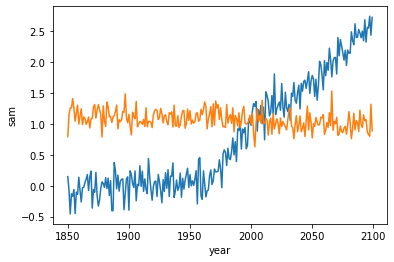

In [24]:
plt.figure()
mean.plot()
std.plot()

# 2. Calculate Compound Years for CESM6

# Define a criteria to determine events

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

Using a piControl climatology

In [27]:
piControlXr=xarray.open_dataset('results/cmip6piControlTradIndeces.nc')

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3',
       'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FIO-ESM-2-0',
       'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
       'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [28]:
# This should calculate stds for all experiments and all indeces
stdXr = piControlXr.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (stdXr[['nino34','dmi']], stdXr['sam']/2)
)

/home/steketea/anaconda3/envs/testEnv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [29]:
criteriaXr

<xarray.Dataset>
Dimensions:  (model: 41)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    nino34   (model) float64 0.7147 0.5967 0.6713 0.86 ... 1.106 1.031 0.7793
    dmi      (model) float64 0.4111 0.6386 0.2419 ... 0.4995 0.4745 0.5384
    sam      (model) float32 0.6323 0.6126 0.548 0.5631 ... 0.5571 0.5424 nan

# Calculate the compounding years and plot an example

In [30]:
for experiment in scenarioSet:

    # Here is the data
    indecesXr = xarray.open_dataset('results/cmip6'+experiment+'TradIndeces.nc')

    firePos, fireNeg = compound.applyCriteria(indecesXr, criteriaXr)

    firePos=compound.compound(firePos)

    fireNeg=compound.compound(fireNeg)

    firePos.to_netcdf('results/cmip6'+experiment+'FirePos.nc')

    fireNeg.to_netcdf('results/cmip6'+experiment+'FireNeg.nc')

firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']


In [31]:
indecesXr.sel(year=2014)

<xarray.Dataset>
Dimensions:          (model: 41)
Coordinates:
    year             int64 2014
  * model            (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables:
    eastIO           (model) float64 0.06348 -0.2154 0.02821 ... -1.179 -0.3089
    eastIONoDetrend  (model) float64 0.6828 0.9454 0.8193 ... 0.1972 0.6959
    nino34NoDetrend  (model) float64 0.7034 0.9514 0.3672 ... 3.171 0.4232
    nino34           (model) float64 0.05546 -0.1803 -0.3853 ... 1.742 -0.5915
    nino4NoDetrend   (model) float64 1.023 1.058 0.5762 ... 0.08605 2.307 0.5863
    dmi              (model) float64 -0.05908 0.09159 ... 1.128 0.0002543
    sam              (model) float64 0.9056 1.064 1.348 ... 1.583 0.7256 nan
    nino4            (model) float64 0.3746 -0.07342 -0.1764 ... 0.8784 -0.4285
Attributes: (12/13)
    experiment:       ssp585
    nino34NoDetrend:  [ 7 15]
    nino4NoDetrend:   [ 7 15]
    eastIONoDetrend:  [ 7 12]
    dmi:              [ 7 12]
    nino34:           [ 7 15]
    ...               ...
    eastIO:           [ 7 12]
    sam:              [10 15]
    lat1:             [10 15]
    lat2:             [10 15]
    precAnom:         [10 15]
    tsAnom:           [10 15]

In [32]:
firePos

<xarray.Dataset>
Dimensions:      (model: 41, year: 450)
Coordinates:
  * year         (year) int64 1850 1851 1852 1853 1854 ... 2296 2297 2298 2299
  * model        (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    dmi          (model, year) float64 0.0 0.0 0.0 0.0 1.0 ... nan nan nan nan
    nino34       (model, year) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    sam          (model, year) float64 0.0 1.0 0.0 1.0 0.0 ... nan nan nan nan
    nEvents      (model, year) float64 2.0 1.0 3.0 1.0 1.0 ... nan nan nan nan
    all3         (model, year) float64 0.0 0.0 1.0 0.0 0.0 ... nan nan nan nan
    nino34+dmi   (model, year) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nino34+sam   (model, year) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    dmi+sam      (model, year) float64 1.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    anyCompound  (model, year) float64 1.0 0.0 1.0 0.0 0.0 ... nan nan nan nan
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']

Text(0.5, 1.0, 'CESM2: Pairs and all-three compounds for individal years')

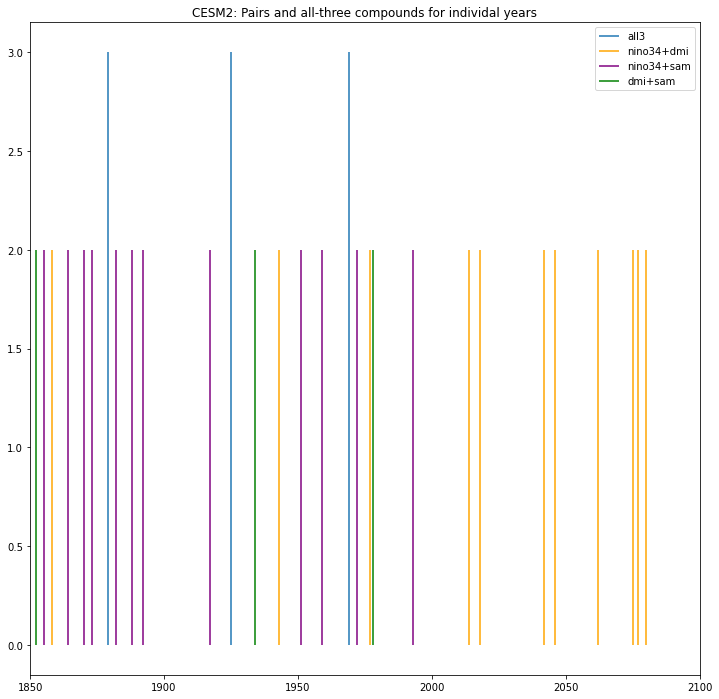

In [33]:
modToPlot = 'CESM2'

toPlot=3*firePos.all3.sel(model=modToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos[iPair].sel(model=modToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1850,2100)
plt.title(modToPlot+': Pairs and all-three compounds for individal years')